In [1]:
library(cowplot)
library(tidyverse)
library(magrittr)
library(ggrepel)
library(UpSetR)

results <- '../results/gwas/' 
exps <- c('t1d', 't2d', 'ra')
methods <- c('Raw', 'LARS', 'Block HSIC Lasso, B = 60', 'mRMR')

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.0.1     ✔ purrr   0.3.0
✔ tidyr   0.8.2     ✔ dplyr   0.7.8
✔ readr   1.3.1     ✔ stringr 1.3.1
✔ tibble  2.0.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()   masks stats::filter()
✖ purrr::flatten()  masks jsonlite::flatten()
✖ cowplot::ggsave() masks ggplot2::ggsave()
✖ dplyr::lag()      masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



In [2]:
lapply(exps, function(e) {
    read_tsv(paste0('../results/gwas/', e, '/', e, '_prediction.tsv'), 
             col_types = 'ciid') %>%
    mutate(model = ifelse(model == 'HSIC_lasso-B=60-M=1, discrete_x = True', 
                          'Block HSIC Lasso, B = 60' , model),
           model = factor(model, levels = methods),
           Phenotype = toupper(e)) %>%
    filter(selected == 10 | is.na(selected))
}) %>% bind_rows %>%
    group_by(Phenotype, model) %>%
    summarize(ended = sum(!is.na(accuracy)),
              sem = (sd(accuracy, na.rm = T) / ended),
              accuracy = mean(accuracy, na.rm = T) %>% round(digits = 3),
              ci = (1.96 * sem / sqrt(ended)) %>% round(digits = 3), 
              fmt_accuracy = paste(accuracy, '±', ci)) %>%
    select(-accuracy, -sem, -ci, -ended) %>%
    spread(key = model, value = fmt_accuracy)

Phenotype,Raw,LARS,"Block HSIC Lasso, B = 60",mRMR
RA,0.671 ± 0.002,0.572 ± 0.002,0.767 ± 0.004,0.776 ± 0.002
T1D,0.671 ± 0.006,0.569 ± 0.004,0.788 ± 0.002,0.799 ± 0.003
T2D,0.609 ± 0.004,0.565 ± 0.005,0.675 ± 0.003,0.689 ± 0.002


# Selected biomarkers

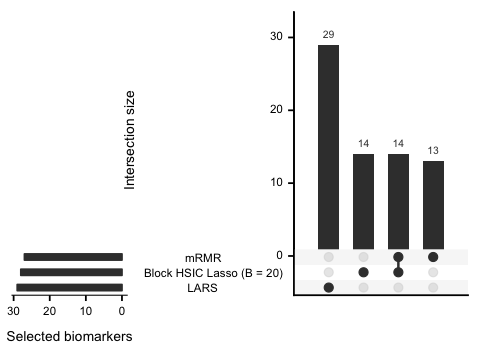

In [3]:
options(repr.plot.width=4, repr.plot.height=3)
selected <- list(LARS = lapply(exps, function(e) {
    read_tsv(paste0(results, e, '/', e, '_lars_C=10.txt'), 
                    col_names = F, col_types = 'c') %>% .$X1 }) %>% unlist %>% c,
                 mRMR = lapply(exps, function(e) {
    read_tsv(paste0(results, e, '/', e, '_mrmr_C=10.txt'), 
                    col_names = F, col_types = 'c') %>% .$X1 }) %>% unlist %>% c,
                 `Block HSIC Lasso (B = 20)` = lapply(exps, function(e) {
    read_tsv(paste0(results, e, '/', e, '_hsic_lasso_C=10_SELECT=50_M=1_B=60.txt'), 
                    col_names = F, col_types = 'c') %>% head(10) %>% .$X1 }) %>% unlist %>% c)

upset(fromList(selected), order.by = "freq", 
      sets.x.label = 'Selected biomarkers', 
      mainbar.y.label = 'Intersection size')

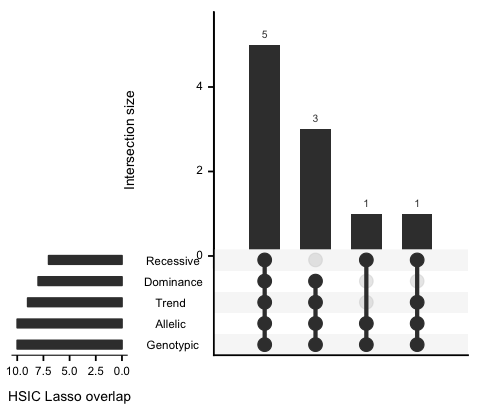

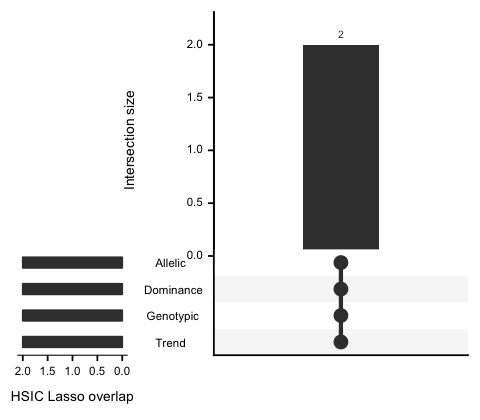

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

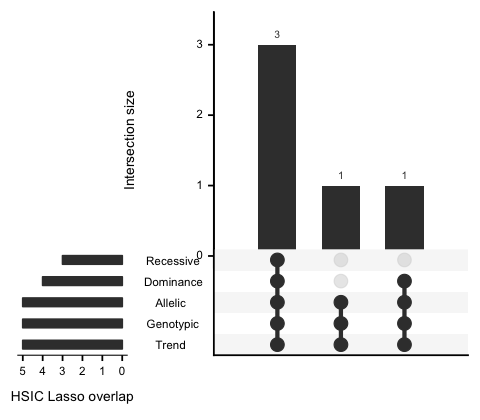

In [4]:
options(repr.plot.width=4, repr.plot.height=3.5)
lapply(exps, function(pheno) {
    
    selected <- read_tsv(paste0(results, pheno, '/', pheno, 
                                '_hsic_lasso_C=10_SELECT=50_M=1_B=60.txt'), 
                     col_names = F, col_types = 'c') %>% 
        head(10) %>%
        set_colnames('snp') %>%
        .$snp
    
    gwas <- read_tsv(paste0(results, pheno, '/univariate_models.tsv'),
                     col_types = 'icddcccd') %>%
        filter(SNP %in% selected & P < (.05 / (4 * n()))) %>%
        mutate(TEST = ifelse(TEST == 'GENO', 'Genotypic', TEST),
               TEST = ifelse(TEST == 'DOM', 'Dominance', TEST),
               TEST = ifelse(TEST == 'TREND', 'Trend', TEST),
               TEST = ifelse(TEST == 'REC', 'Recessive', TEST),
               TEST = ifelse(TEST == 'ALLELIC', 'Allelic', TEST)) %>%
        select(SNP, TEST)
    
    gwas <- fromList(split(gwas$SNP, gwas$TEST))
    
    upset(gwas, order.by = "freq", 
          sets.x.label = 'HSIC Lasso overlap', 
          mainbar.y.label = 'Intersection size', 
          mb.ratio = c(.6, .4), 
          point.size = 3.5, line.size = 1.2)

})

In [5]:
manhattan <- function(pheno) {
    
    map <- read_tsv('../results/gwas/t1d/controls.bim',
                    col_names = F, col_types = 'iciiii') %>%
           set_colnames(c('chr', 'snp', 'cm', 'pos', 'x1', 'x2')) %>%
           select(-cm, -x1, -x2)
    
    snp2gene <- read_tsv(paste0(results, 'snp2hgnc.tsv'), 
                     col_types = 'cc')
    
    selected <- read_tsv(paste0(results, pheno, '/', pheno, 
                                '_hsic_lasso_C=10_SELECT=50_M=1_B=60.txt'), 
                     col_names = F, col_types = 'c') %>%
        head(10) %>%
        set_colnames('snp') %>%
        .$snp
    
    gwas <- read_tsv(paste0(results, pheno, '/univariate_models.tsv'),
                     col_types = 'icddcccd') %>%
        rename(chr = CHR, snp = SNP) %>%
        filter(TEST == 'GENO') %>%
        inner_join(map, by = c('chr', 'snp')) %>%
        mutate(selected = ifelse(snp %in% selected, 'Yes', 'No'),
               P = P + 1e-220) %>%
        arrange(selected)

    don <- gwas %>% 

      # Compute chromosome size
      group_by(chr) %>% 
      summarise(chr_len=max(pos)) %>% 

      # Calculate cumulative position of each chromosome
      mutate(tot=cumsum(chr_len)-chr_len) %>%
      select(-chr_len) %>%

      # Add this info to the initial dataset
      left_join(gwas, ., by='chr') %>%

      # Add a cumulative position of each SNP
      arrange(chr, pos) %>%
      mutate( BPcum=pos+tot) %>%
      left_join(arrange(snp2gene, symbol) %>% group_by(snp) %>% summarize(symbol = head(symbol, 1)), by = 'snp')

    bf_threshold <- .05 / (nrow(gwas))
    y_lim <- max(-log10(don$P), na.rm = TRUE) + 15
    axisdf <- don %>% group_by(chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

    ggplot(don, aes(x=BPcum, y=-log10(P))) +

        # Show all points
        geom_point( aes(color=as.factor(chr)), alpha=0.8, size=1.3) +
        geom_point(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(P)), color = 'black') +
        scale_color_manual(values = rep(c("grey", "skyblue"), 22 )) +

        # Add Bonferroni line
        geom_hline(yintercept = -log10(bf_threshold), color = 'red') +
    
        # add gene symbols
        geom_text_repel(data = filter(don, selected == 'Yes' & !is.na(symbol)), 
                        aes(x=BPcum, y=-log10(P), label = symbol), size = 5) +

        # custom X axis:
        scale_x_continuous( label = axisdf$chr, breaks= axisdf$center ) +
        scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

        # Custom the theme:
        theme_bw() +
        theme( 
          legend.position="none",
          panel.border = element_blank(),
          axis.title = element_text(size = 15),
          axis.text = element_text(size = 12),
          strip.text.y = element_text(size = 15),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank()
        ) +
        labs(x = 'Chromosome', y = bquote('-log' [10] ~'(p-value)'))
    
}

In [6]:
ra_plt <- manhattan('ra')
t1d_plt <- manhattan('t1d')
t2d_plt <- manhattan('t2d')

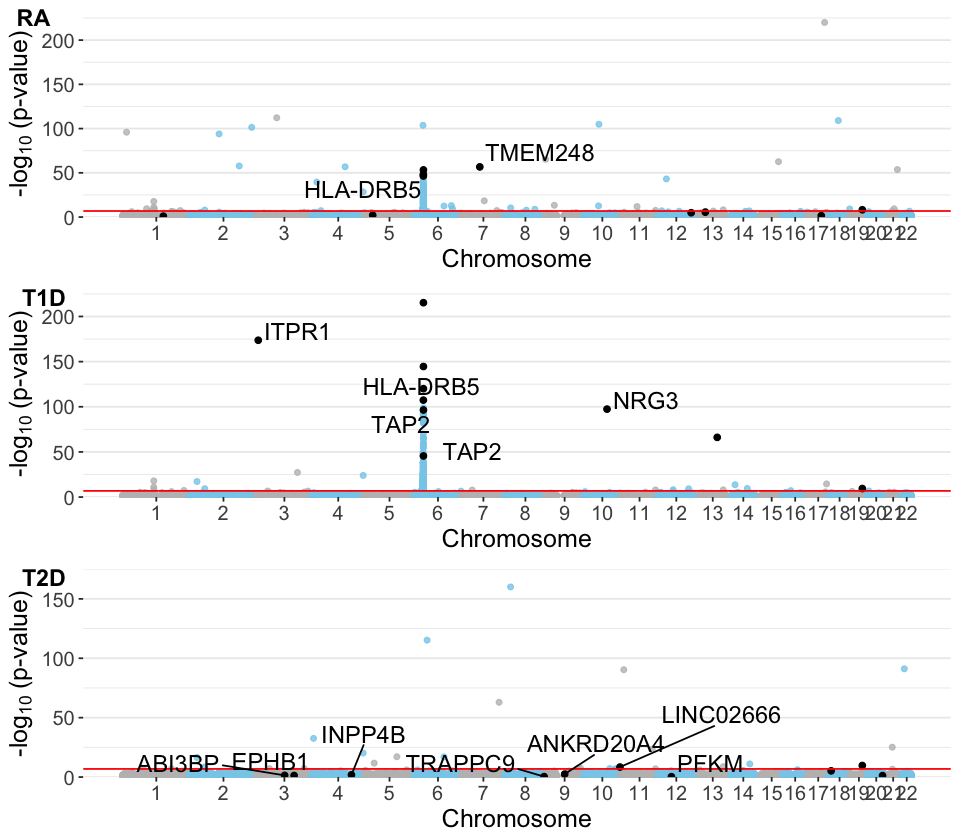

In [7]:
options(repr.plot.width=8, repr.plot.height=7)
plot_grid(ra_plt, t1d_plt, t2d_plt, nrow = 3,
          labels = c('RA', 'T1D', 'T2D'))

# Linkage disequilibrium in HLA region

In [8]:
biomarkers_hl <- read_tsv(paste0(results, 't1d/t1d_hsic_lasso_C=10_SELECT=50_M=1_B=60.txt'), 
                       col_types = 'c', col_names = FALSE) %>%
    head(10) %>%
    .$X1

biomarkers_p <- read_tsv(paste0(results, 't1d/univariate_models.tsv'),
                         col_types = 'icddcccd')  %>%
    filter(CHR == 6) %>%
    filter(TEST == 'GENO' & P <= .05 / n()) %>%
    .$SNP

ld_hl <- read_tsv(paste0(results, 't1d/hla_biomarkers_ld.txt'), col_types = 'iiciicd') %>%
    filter(CHR_A == 6 & SNP_A %in% biomarkers_hl & SNP_B %in% biomarkers_hl) %>%
    mutate(origin = 'HSIC Lasso')

ld_ctrl <- read_tsv(paste0(results, 't1d/hla_biomarkers_ld.txt'), col_types = 'iiciicd') %>%
    filter((CHR_A == 6 & BP_A > 32393963 & BP_A < 33087201) & 
           (CHR_B == 6 & BP_B > 32393963 & BP_B < 33087201)) %>%
    filter(SNP_A %in% biomarkers_p & SNP_B %in% biomarkers_p) %>%
    mutate(origin = 'All biomarkers')

ld <- bind_rows(ld_hl, ld_ctrl)

summary(ld_hl$R)
summary(ld_ctrl$R)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.23516 -0.07031  0.74583  0.52132  1.00000  1.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.8051 -0.2753  0.3827  0.2854  0.8844  1.0000 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


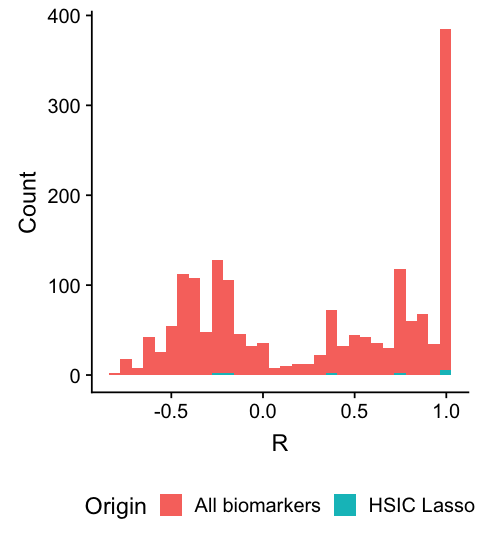

In [9]:
options(repr.plot.width=4, repr.plot.height=4.5)
ggplot(ld, aes(R, fill = origin)) +
    geom_histogram() +
    labs(y = 'Count', fill = 'Origin') +
    theme(legend.position = 'bottom')

# Gene set enrichment analysis

In [10]:
suppressPackageStartupMessages(library(clusterProfiler))
suppressPackageStartupMessages(library(org.Hs.eg.db))

In [11]:
snp2gene <- read_tsv(paste0(results, 'snp2hgnc.tsv'), 
                     col_types = 'cc')

biomarkers <- lapply(exps, function(pheno) { 
    read_tsv(paste0(results, pheno, '/', pheno, 
                    '_hsic_lasso_C=10_SELECT=50_M=1_B=60.txt'), 
             col_names = F, col_types = 'c') %>%
        set_colnames('snp') %>%
        mutate(phenotype = pheno,
               rank = seq(1, n()))
}) %>% bind_rows %>%
    inner_join(snp2gene, by = "snp")

In [12]:
enrichGO(gene    = unique(biomarkers$symbol[biomarkers$phenotype == 'ra']),
         OrgDb   = org.Hs.eg.db,
         keyType = 'SYMBOL') %>%
    as_tibble

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count


In [13]:
enrichGO(gene    = unique(biomarkers$symbol[biomarkers$phenotype == 't1d']),
         OrgDb   = org.Hs.eg.db,
         keyType = 'SYMBOL') %>%
    as_tibble

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
GO:0042605,peptide antigen binding,3/24,30/17632,8.781690e-06,0.0009659859,0.0005823647,HLA-DRB5/HLA-DRB1/TAP1,3
GO:0032395,MHC class II receptor activity,2/24,10/17632,7.937470e-05,0.0043656087,0.0026318981,HLA-DQA2/HLA-DOB,2
GO:0003823,antigen binding,4/24,199/17632,1.401478e-04,0.0051387530,0.0030980042,HLA-DRB5/HLA-DRB1/TAP1/IGLV10-54,4
GO:0023026,MHC class II protein complex binding,2/24,16/17632,2.106122e-04,0.0057918362,0.0034917290,HLA-DRB1/HLA-DOB,2
GO:0023023,MHC protein complex binding,2/24,20/17632,3.323621e-04,0.0073119668,0.0044081714,HLA-DRB1/HLA-DOB,2
GO:1904680,peptide transmembrane transporter activity,2/24,32/17632,8.590305e-04,0.0157488919,0.0094945473,TAP2/TAP1,2
GO:0042287,MHC protein binding,2/24,36/17632,1.087488e-03,0.0170890975,0.0103025181,TAP2/TAP1,2
GO:0042887,amide transmembrane transporter activity,2/24,44/17632,1.622147e-03,0.0223045230,0.0134467459,TAP2/TAP1,2


In [14]:
enrichGO(gene    = unique(biomarkers$symbol[biomarkers$phenotype == 't2d']),
         OrgDb   = org.Hs.eg.db,
         keyType = 'SYMBOL') %>%
    as_tibble

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
